In [87]:
# !pip install pymc3
import theano
from theano import tensor as tt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from theano import shared
from collections import OrderedDict
from time import time
import pymc3 as pm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import bs4 as bs
import urllib.request
import re
import nltk

## PyStan

In [1]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(alpha, 3);
    y ~ normal(alpha + beta * x, sigma);
}
"""

In [2]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


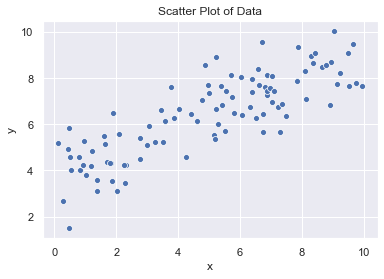

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
fig.show()

In [4]:
my_data = {'N': len(x), 'x':x, 'y':y}

# compile the model
sm = pystan.StanModel(model_code = model)

# Train the model and generate samples
fit = sm.sampling(data=my_data, iter=1000, chains=4, warmup=500,
                 thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5dac76512503e16d165a1650e73d6591 NOW.


In [5]:
fit

Inference for Stan model: anon_model_5dac76512503e16d165a1650e73d6591.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  7.8e-3    0.2   3.43   3.71   3.84   3.99   4.25    689    1.0
beta    0.52  1.4e-3   0.04   0.45   0.49   0.52   0.54   0.59    695   1.01
sigma   1.02  2.2e-3   0.07   0.89   0.97   1.02   1.06   1.17   1055    1.0
lp__  -50.67    0.05    1.2 -53.74 -51.18 -50.38 -49.82 -49.27    660   1.01

Samples were drawn using NUTS at Sun Apr  5 13:17:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [35]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [36]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.847233,0.007791,0.204476,3.432199,3.712045,3.843945,3.988621,4.247307,688.824561,1.003806
beta,0.518992,0.001357,0.035774,0.451554,0.494031,0.519022,0.542252,0.592751,694.847442,1.005137
sigma,1.018336,0.002230,0.072411,0.889964,0.966515,1.015352,1.062878,1.171441,1054.666326,1.003536
lp__,-50.670761,0.046689,1.199146,-53.741125,-51.180655,-50.381009,-49.823333,-49.274058,659.640882,1.009254


In [37]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

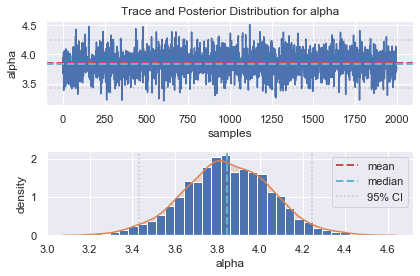

In [38]:
plot_trace(alpha, 'alpha')

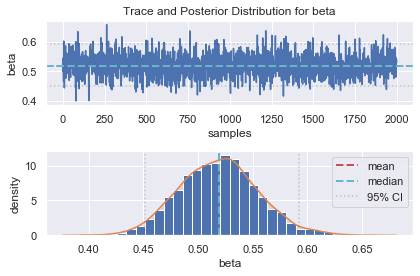

In [39]:
plot_trace(beta, 'beta')

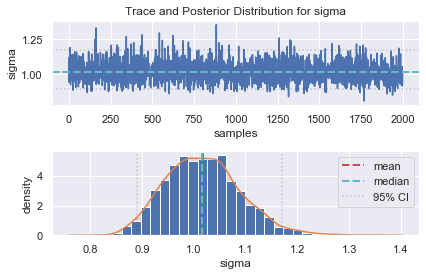

In [40]:
plot_trace(sigma, 'sigma')

## PyMC3

### Dirichlet Process

### Stick Breaking

In [32]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [48]:
dp = pm.Model()

with dp:
    alpha = 10*pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=5)
    pi = pm.Deterministic('pi', stick_breaking(beta))
    
with dp:
    trace = pm.sample(8, tune=10, init='advi', random_seed=1)

INFO (theano.gof.compilelock): Refreshing lock /Users/sean/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Only 8 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1.4419:   3%|▎         | 5538/200000 [00:02<01:42, 1899.79it/s]
Convergence achieved at 5700
Interrupted at 5,699 [2%]: Average Loss = 1.7765
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 36/36 [00:00<00:00, 441.73draws/s]
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [49]:
trace['pi']

array([[0.08255686, 0.01758825, 0.1280402 , 0.00160101, 0.03747902],
       [0.02770362, 0.05633033, 0.02263968, 0.05427781, 0.03800663],
       [0.00703933, 0.04782634, 0.04621356, 0.03931023, 0.06143881],
       [0.08720952, 0.10587597, 0.06642946, 0.02547601, 0.04486711],
       [0.05629482, 0.08233682, 0.046477  , 0.06859775, 0.01847677],
       [0.07159693, 0.12368721, 0.03780695, 0.06984617, 0.01275361],
       [0.17026018, 0.06931744, 0.01052138, 0.12258739, 0.00518322],
       [0.13788845, 0.2551231 , 0.00414447, 0.07065476, 0.00551783],
       [0.02221211, 0.11353412, 0.00885212, 0.1697861 , 0.03130998],
       [0.01225221, 0.17187463, 0.00631393, 0.0627484 , 0.00734137],
       [0.03570415, 0.08380812, 0.0149215 , 0.04450117, 0.01465119],
       [0.00437026, 0.02667629, 0.0746188 , 0.06662505, 0.08946753],
       [0.36386073, 0.02116921, 0.01601512, 0.02771745, 0.00905379],
       [0.03113594, 0.43437706, 0.20732762, 0.03595916, 0.15363983],
       [0.00524352, 0.11562413, 0.

In [50]:
trace['alpha']

array([0.46764439, 2.44812257, 1.18289501, 2.16445973, 0.87446453,
       1.1257744 , 1.13517081, 0.85344313, 2.35141001, 1.92047113,
       1.69611032, 1.5402349 , 0.75513879, 0.36260198, 0.4312461 ,
       0.71084217])

## DP Mixture Model with MCMC and ADVI

In [2]:
# import some data to play with
iris = datasets.load_iris()
iris['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [12]:
faith = pd.read_csv('faithful.csv')
faith.waiting.values

array([79, 54, 74, 62, 85, 55, 88, 85, 51, 85, 54, 84, 78, 47, 83, 52, 62,
       84, 52, 79, 51, 47, 78, 69, 74, 83, 55, 76, 78, 79, 73, 77, 66, 80,
       74, 52, 48, 80, 59, 90, 80, 58, 84, 58, 73, 83, 64, 53, 82, 59, 75,
       90, 54, 80, 54, 83, 71, 64, 77, 81, 59, 84, 48, 82, 60, 92, 78, 78,
       65, 73, 82, 56, 79, 71, 62, 76, 60, 78, 76, 83, 75, 82, 70, 65, 73,
       88, 76, 80, 48, 86, 60, 90, 50, 78, 63, 72, 84, 75, 51, 82, 62, 88,
       49, 83, 81, 47, 84, 52, 86, 81, 75, 59, 89, 79, 59, 81, 50, 85, 59,
       87, 53, 69, 77, 56, 88, 81, 45, 82, 55, 90, 45, 83, 56, 89, 46, 82,
       51, 86, 53, 79, 81, 60, 82, 77, 76, 59, 80, 49, 96, 53, 77, 77, 65,
       81, 71, 70, 81, 93, 53, 89, 45, 86, 58, 78, 66, 76, 63, 88, 52, 93,
       49, 57, 77, 68, 81, 81, 73, 50, 85, 74, 55, 77, 83, 83, 51, 78, 84,
       46, 83, 55, 81, 57, 76, 84, 77, 81, 87, 77, 51, 78, 60, 82, 91, 53,
       78, 46, 77, 84, 49, 83, 71, 80, 49, 75, 64, 76, 53, 94, 55, 76, 50,
       82, 54, 75, 78, 79

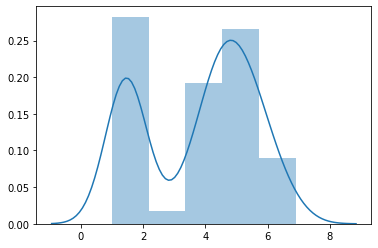

In [13]:
from sklearn import datasets

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# data = faith.waiting.values
data = iris['data'][:,2]
import seaborn as sns
sns.distplot(data)

In [49]:
K = 30

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=data)

### MCMC

In [31]:
SEED = 1
with model:
    step_metro = pm.step_methods.metropolis.Metropolis()
    step_hmc = pm.step_methods.hmc.hmc.HamiltonianMC()
    step_nuts = pm.step_methods.hmc.nuts.NUTS()
    
    step = step_nuts
    trace = pm.sample(200, step, random_seed=SEED, init='advi')

Only 200 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains, 49 divergences: 100%|██████████| 1400/1400 [00:18<00:00, 77.02draws/s] 
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


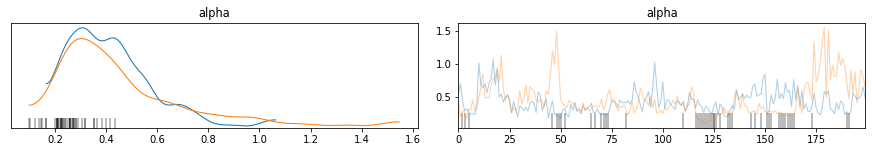

In [32]:
pm.traceplot(trace, var_names=['alpha']);

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a290571d0>,
      dtype=object)

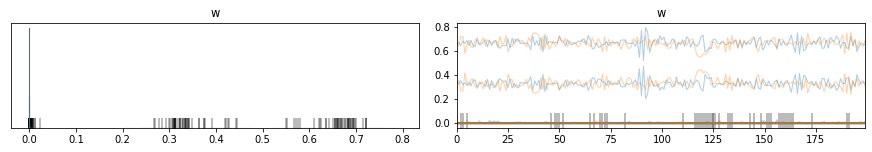

In [33]:
pm.traceplot(trace, var_names=['w'])

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a237c9048>,
      dtype=object)

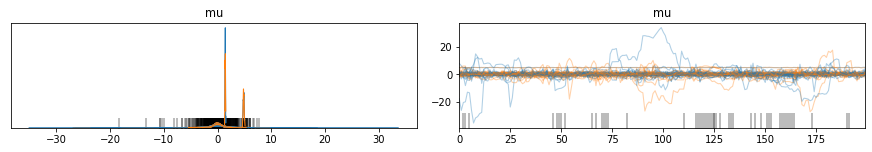

In [34]:
pm.traceplot(trace, var_names=['mu'])

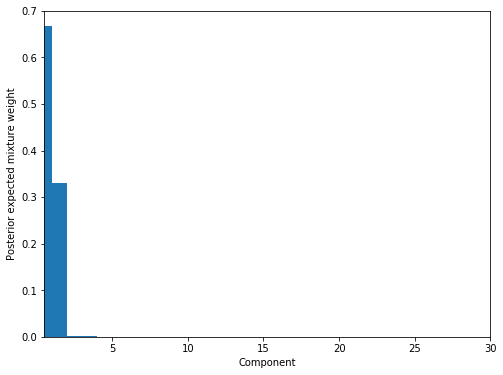

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### ADVI

In [65]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
# doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
# doc_t = shared(docs_tr.toarray()[:minibatch_size])

# local_RVs = OrderedDict([alpha, beta, mu])
    
with model:
#     approx = pm.MeanField(local_rv=local_RVs)
    approx = pm.MeanField()
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(10000, callbacks=[reduce_rate], 
              obj_optimizer=pm.sgd(learning_rate=s))
#               more_obj_params=encoder_params, 
#               total_grad_norm_constraint=200,
#               more_replacements={doc_t: doc_t_minibatch})
                  

Average Loss = inf:   0%|          | 0/10000 [00:00<?, ?it/s]    


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `tau_log__`.ravel()[1] is NaN.
The current approximation of RV `lambda_interval__`.ravel()[1] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [39]:
with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 318.2: 100%|██████████| 4500/4500 [00:05<00:00, 852.74it/s] 
Finished [100%]: Average Loss = 318.11


CPU times: user 6.21 s, sys: 634 ms, total: 6.84 s
Wall time: 8.18 s


In [52]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

/Users/sean/.conda/envs/shenseanchen/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [54]:
means.keys()

dict_keys(['mu', 'alpha_log__', 'beta_logodds__', 'tau_log__', 'lambda_interval__'])

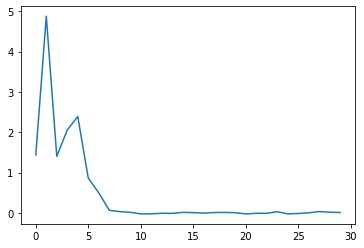

In [55]:
plt.plot(means['mu'])

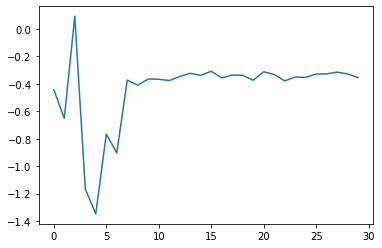

In [57]:
plt.plot(means['tau_log__'])

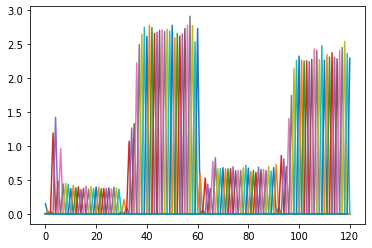

In [47]:
plt.plot(cov)

## Text Data - word2vec embeddings

### Loading Data

In [72]:
# The number of words in the vocabulary
n_words = 50

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                max_features=n_words, 
                                # If not None, build a vocabulary that 
                                # only consider the top max_features 
                                # ordered by term frequency across the corpus.
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.459s.
Extracting tf features for LDA...
done in 2.038s.


In [82]:
tf.toarray()[0:5].shape

(5, 50)

In [84]:
data_samples[0:5]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [81]:
feature_names

['10',
 'available',
 'ax',
 'believe',
 'bit',
 'com',
 'data',
 'did',
 'does',
 'don',
 'edu',
 'file',
 'god',
 'going',
 'good',
 'government',
 'information',
 'just',
 'key',
 'know',
 'like',
 'll',
 'make',
 'max',
 'need',
 'new',
 'number',
 'people',
 'point',
 'problem',
 'program',
 'really',
 'right',
 'said',
 'say',
 'space',
 'thanks',
 'things',
 'think',
 'time',
 'use',
 'used',
 'using',
 've',
 'want',
 'way',
 'windows',
 'work',
 'year',
 'years']

### Preprocessing

In [111]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/sean/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sean/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:
len(data_samples)

11314

In [120]:
# Cleaing the text
processed_article = ''
for paragraph in data_samples[:100]:
    processed_article += paragraph
    processed_article += ' '

In [121]:
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)

# Preparing the dataset
all_sentences = nltk.sent_tokenize(processed_article)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]


# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]
    

from gensim.models import Word2Vec

word2vec = Word2Vec(all_words, size=5, min_count=1)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5965 word types from a corpus of 15621 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 5965 unique words (100% of original 5965, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 15621 word corpus (100% of original 15621, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5965 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 18 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 15105 word corpus (96.7% of prior 15621)
INFO:gensim.models.base_any2vec:estimated required memory for 5965 words and 5 dimensions: 3221100 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model with 3 wor

In [122]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'Well': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f080>, 'sure': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f278>, 'story': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f0f0>, 'nad': <gensim.models.keyedvectors.Vocab object at 0x1a34b8fb38>, 'seem': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f6a0>, 'biased': <gensim.models.keyedvectors.Vocab object at 0x1a34b8fef0>, 'What': <gensim.models.keyedvectors.Vocab object at 0x1a34b8fc18>, 'I': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f4e0>, 'disagree': <gensim.models.keyedvectors.Vocab object at 0x1a34b8ff28>, 'statement': <gensim.models.keyedvectors.Vocab object at 0x1a34b8f320>, 'U': <gensim.models.keyedvectors.Vocab object at 0x1a34b909b0>, 'S': <gensim.models.keyedvectors.Vocab object at 0x1a34b90dd8>, 'Media': <gensim.models.keyedvectors.Vocab object at 0x1a34b90c18>, 'ruin': <gensim.models.keyedvectors.Vocab object at 0x1a34b90b70>, 'Israels': <gensim.models.keyedvectors.Vocab object at 0x1

In [123]:
word2vec.wv['try'].shape

(5,)

In [126]:
word2vec.wv['try']

array([-0.06763582, -0.07606616,  0.03678559, -0.07724277,  0.00355774],
      dtype=float32)

In [129]:
sim_words = word2vec.wv.most_similar('ignore')
sim_words

[('nodes', 0.9701098799705505),
 ('listserv', 0.9643518924713135),
 ('expansion', 0.9565151929855347),
 ('char', 0.9486656188964844),
 ('several', 0.9469623565673828),
 ('sunk', 0.9449036717414856),
 ('Continues', 0.940908670425415),
 ('Korea', 0.9388653635978699),
 ('luck', 0.9352318644523621),
 ('Mormon', 0.9343061447143555)]

## Multivariate Normal Mixture HDP

In [125]:
from sklearn import datasets
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# import some data to play with
iris = datasets.load_iris()
iris['data']

# data = faith.waiting.values
data = iris['data'][:,1:3]

dim = np.shape(data)[1]
dim

2

### Multivariate Normal DP

In [ ]:
K_topics = 50
M_topics_per_doc = 20


with pm.Model() as model:
    
    # Topics DP
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    G_0 = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau)

    # Doc DP
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    cov = np.array([[1., 0.5], [0.5, 2]])
    mu = np.zeros(2)
    vals = pm.MvNormal('vals', mu=mu, cov=cov, shape=(5, 2), observed=data)

### Multivariate Normal HDP

In [ ]:
K_topics = 50
M_topics_per_doc = 20


with pm.Model() as model:
    
    # Topics DP
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    G_0 = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau)

    # Doc DP
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    cov = np.array([[1., 0.5], [0.5, 2]])
    mu = np.zeros(2)
    vals = pm.MvNormal('vals', mu=mu, cov=cov, shape=(5, 2), observed=data)